In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.utils import shuffle
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import tensorflow_addons as tfa

import numpy as np
import matplotlib.pyplot as plt


from sklearn import decomposition
from sklearn import datasets
%matplotlib inline

In [66]:
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

In [67]:
data_path = '/home/shellygoel2324/data_merged.csv'
#labels_path = '/home/shellygoel2324/processedLabels.csv'

In [87]:
def load_pose_landmarks(csv_path):
    """Loads a CSV created by MoveNetPreprocessor.
    Returns:
        X: Detected landmark coordinates and scores of shape (N, 17 * 3)
        y: Ground truth labels of shape (N, label_count)
        classes: The list of all class names found in the dataset
        dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
        truth labels (y) to use later to train a pose classification model.
    """

    # Load the CSV file
    dataframe = pd.read_csv(csv_path)
    
    dataframe["label"] = dataframe["label"] - 1
  
    print(dataframe["label"].unique())
   
    curr_num = dataframe.loc[dataframe['label'] == 0]
    
    dataFinal = curr_num.sample(n=5000)
    #print(f"{i}:{curr_num_sub.shape}")
    #dataFinal.append(curr_num_sub)
    
    print(f"{0}:{dataFinal.shape}")
    
    '''
    0: 5000
    1:2500*2
        2: 1000*5
            3:250*20
                4: 250*20
                    5: 50*100
                
    '''
        
    for i in range(1, 6):
        
        curr_num = dataframe.loc[dataframe['label'] == i]
        
        '''
        num_s = 0
        if i == 1:
            num_s = 2
        if i == 2:
            num_s = 5
        if i == 3:
            num_s = 20
        if i == 4:
            num_s = 20     
        if i == 5:
            num_s = 100
            '''
        
        if i in [2,4]:
            sample_n = 7500
            
        if i == 3:
            sample_n = 8500
        elif i == 0:
            sample_n = 8000
        elif i == 1:
            sample_n = 8500
            
        else:
            sample_n = 5000
        
        curr_num_sub = curr_num.sample(n=sample_n, replace = True)
        print(f"{i}:{curr_num_sub.shape}")
        dataFinal = dataFinal.append(curr_num_sub, ignore_index=True)
        
    
    
    #print(dataFinal.shape)
    
    dataframe = dataFinal
    labels = dataframe["label"]#pd.read_csv(labels_path, header=None)
    
    #print(labels.unique())
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    df_to_process.pop('class_name')
    df_to_process.pop('class_no')
    df_to_process.pop('label')

    # Extract the labels
    y = labels
    classes = range(6)
    
    #print(df_to_process.columns)

    
    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)

    return X, y, classes, dataframe

In [99]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(data_path)

#print(X.shape, y.shape)

#RUN PCA

#group by joint

points = []


X = X.reset_index()  # make sure indexes pair with number of rows
for index, row in X.iterrows():
    if index == 0: 
        continue
    newRow = []
    for i in range(0,51,3):        
        newRow.append(row[i:i+3])
    newRow = np.asarray(newRow)
    #print(newRow)
    #print("new row shape: ", newRow.shape)

    points.append(newRow)

 

data_2d = np.array([features_2d.flatten() for features_2d in points])
pca = PCA(n_components=30)
pca.fit(data_2d)
data_pca = pca.transform(data_2d)
print("original shape:   ", data_2d.shape) ##(69,2640*7680)
print("transformed shape:", data_pca.shape)

'''
points = np.asarray(points)
print("POINTS: ",points.shape)
pca = decomposition.PCA(n_components=10)
pca.fit(points)
X_new = pca.transform(points)
print("new shapes:",X.shape,X_new.shape)
#X = X_new
'''

print(X.shape)
X = data_pca
y = y[:-1]


# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)

# 80/10/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1) # 0.25 x 0.8 = 0.2

print(X_train.shape, X_val.shape, X_test.shape)

#60/20/20
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

[0. 3. 1. 2. 4. 5.]
0:(5000, 55)
1:(8500, 55)
2:(5000, 55)
3:(8500, 55)
4:(5000, 55)
5:(5000, 55)
original shape:    (36999, 51)
transformed shape: (36999, 30)
(37000, 52)
(29599, 30) (3700, 30) (3700, 30)


In [112]:
print(X[0])
X_new, y_new, class_names_new, _ = load_pose_landmarks(data_path)



print(X_new.iloc[0])

[-1.84981906e+04  1.84141947e+02  5.68490285e+01  6.15830773e+00
 -1.09739701e+01 -6.25377900e+00  7.41278062e+00  5.04051740e+00
  2.29960073e+00 -3.41383021e+00 -3.09856855e+00 -1.32163612e-01
 -1.20083800e+00 -2.44407709e+00  2.43835109e+00 -6.29117439e-02
 -6.41447729e-01  3.39346618e+00 -3.95940943e-01 -1.05423271e+00
  3.78483243e-01  1.15035672e+00  1.33949772e+00  7.40063550e-01
 -1.27199591e-01  4.33237545e-01 -6.60334470e-02  3.20567841e-01
 -4.38168121e-01  3.24989617e-01]
[0. 3. 1. 2. 4. 5.]
0:(5000, 55)
1:(8500, 55)
2:(5000, 55)
3:(8500, 55)
4:(5000, 55)
5:(5000, 55)
NOSE_x                  202.000000
NOSE_y                   87.000000
NOSE_score                0.447463
LEFT_EYE_x              206.000000
LEFT_EYE_y               84.000000
LEFT_EYE_score            0.562338
RIGHT_EYE_x             199.000000
RIGHT_EYE_y              83.000000
RIGHT_EYE_score           0.536214
LEFT_EAR_x              212.000000
LEFT_EAR_y               85.000000
LEFT_EAR_score            0.

In [100]:
print("TRAIN DISTRIBUTION")

sample_dist = []
for i in range(0,6):
    
    num_i = 0
    for sample in y_train:
            if tf.argmax(sample) == i:
                num_i+=1
    dist = num_i/len(y_train)
    print(f"{i}: {dist}")
    print(f"{i}: {num_i}")
    sample_dist.append(dist)


print("\nTEST DISTRIBUTION")
for i in range(0,6):
    
    num_i = 0
    for sample in y_test:
            if tf.argmax(sample) == i:
                num_i+=1

    dist = num_i/len(y_test)
    print(f"{i}: {dist}")
    #sample_dist.append(dist)

TRAIN DISTRIBUTION
0: 0.13439643231190243
0: 3978
1: 0.22798067502280484
1: 6748
2: 0.13530862529139498
2: 4005
3: 0.23085239366194804
3: 6833
4: 0.13584918409405722
4: 4021
5: 0.1356126896178925
5: 4014

TEST DISTRIBUTION
0: 0.1437837837837838
1: 0.2308108108108108
2: 0.13378378378378378
3: 0.22648648648648648
4: 0.13405405405405404
5: 0.13108108108108107


In [101]:
sample_dist = sample_dist/np.linalg.norm(sample_dist)
weight_balanced= [1/s for s in sample_dist]

print(sample_dist)
print(weight_balanced)
#weight_balanced = weight_balanced/np.linalg.norm(weight_balanced)
#print(weight_balanced)
#print(np.sum(weight_balanced))

[0.31811732 0.53963189 0.32027649 0.54642927 0.32155599 0.32099621]
[3.143494376686998, 1.853115090465453, 3.122302279765513, 1.8300630221660878, 3.1098782965582887, 3.115301602008191]


In [102]:
class_weights = {}
for i in range(6):
    class_weights[i] = weight_balanced[i]

In [103]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""
    
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.

        It is the maximum of two values:
        * Torso size multiplied by `torso_size_multiplier`
        * Maximum distance from pose center to any pose landmark
    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (10*2), 10, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

    return pose_size


def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (10*2), 10, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks


def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(10, 3)
    reshaped_inputs = keras.layers.Reshape((10, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

def no_normalization(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    landmarks = keras.layers.Reshape((10, 3))(landmarks_and_scores)

    # Flatten the landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks[:, :, :2])

    return embedding

In [104]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Plots the confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## Normalize everything

In [105]:

import tensorflow_transform as tft
from sklearn.decomposition import PCA

# Define the model
inputs = tf.keras.Input(shape=(30))
print("input :",inputs.shape)
embedding = landmarks_to_embedding(inputs)


print("Embedding: ", embedding.shape)

#pca = PCA(n_components=10)
#pca.fit(embedding)


#embedding_pca = tft.pca(
 #   embedding,10, dtype=tf.float32)


#print(t)
#print(embedding_pca.shape)

#pca = decomposition.PCA(n_components=10)
#pca.fit(embedding)
#X_new = pca.transform(embedding)
#print("PCA shape: ", X_new.shape)
#RUN PCA HERE!
layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

input : (None, 30)
Embedding:  (None, 20)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 reshape_28 (Reshape)           (None, 10, 3)        0           ['input_29[0][0]']               
                                                                                                  
 tf.__operators__.getitem_22 (S  (None, 10, 2)       0           ['reshape_28[0][0]']             
 licingOpLambda)                                                                                  
                                                                                                  
 tf.compat.v1.gather_198 (TFOpL  (None, 2)        

 da)                                                                                              
                                                                                                  
 tf.math.multiply_201 (TFOpLamb  (None, 2)           0           ['tf.compat.v1.gather_201[0][0]']
 da)                                                                                              
                                                                                                  
 tf.broadcast_to_45 (TFOpLambda  (None, 10, 2)       0           ['tf.expand_dims_45[0][0]',      
 )                                                                'tf.compat.v1.floor_div_45[0][0]
                                                                 ']                               
                                                                                                  
 tf.__operators__.add_90 (TFOpL  (None, 2)           0           ['tf.math.multiply_202[0][0]',   
 ambda)   

In [106]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [107]:
model.compile(
    optimizer='adam',
    loss=tfa.losses.SigmoidFocalCrossEntropy(),#'categorical_crossentropy',
    metrics=METRICS
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
#checkpoint_path = "weights.best.hdf5"

checkpoint_path = "weights.best.onlyfocalloss"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200


InvalidArgumentError: Graph execution error:

Detected at node 'model_5/tf.compat.v1.gather_199/GatherV2' defined at (most recent call last):
    File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 473, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 462, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 369, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 664, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 355, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2958, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3003, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3229, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3444, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3524, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_14169/2898476920.py", line 25, in <module>
      callbacks=[checkpoint, earlystopping])
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py", line 452, in call
      inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/layers/core/tf_op_layer.py", line 226, in _call_wrapper
      return self._call_wrapper(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/layers/core/tf_op_layer.py", line 261, in _call_wrapper
      result = self.function(*args, **kwargs)
Node: 'model_5/tf.compat.v1.gather_199/GatherV2'
indices = 12 is not in [0, 10)
	 [[{{node model_5/tf.compat.v1.gather_199/GatherV2}}]] [Op:__inference_train_function_5004966]

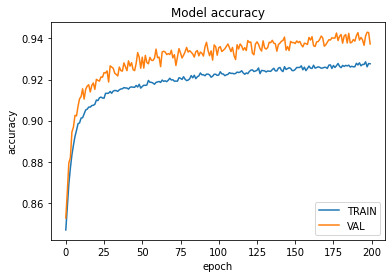

In [19]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

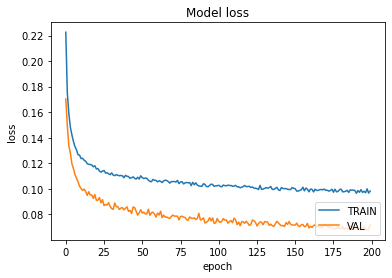

In [20]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [21]:
loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc = model.evaluate(X_test, y_test)

116/116 [==============================] - 0s 2ms/step - loss: 0.0713 - tp: 2392.0000 - fp: 46.0000 - tn: 18454.0000 - fn: 1308.0000 - accuracy: 0.9390 - precision: 0.9811 - recall: 0.6465 - auc: 0.9867 - prc: 0.9473


Normalized confusion matrix

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.83      0.88       532
           1       0.90      0.83      0.86       854
           2       0.90      0.73      0.81       484
           3       0.81      0.88      0.84       812
           4       0.76      0.99      0.86       504
           5       0.99      1.00      0.99       514

    accuracy                           0.87      3700
   macro avg       0.89      0.88      0.88      3700
weighted avg       0.88      0.87      0.87      3700



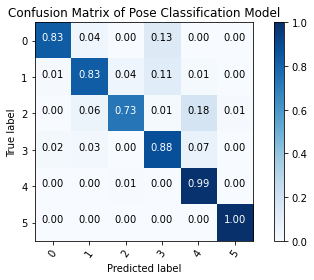

In [22]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,normalize=True,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [18]:
#Classes 3, 4 Need to be weighted

